In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LEAR

In [2]:
df = pd.read_csv(r"Data/df_espana_final.csv")

In [3]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Exogenous 4
0,2019-01-02 00:00:00,64.03,24914.0,5795.0,0.0,19.500
1,2019-01-02 01:00:00,61.74,22758.0,6460.0,0.0,24.400
2,2019-01-02 02:00:00,53.00,20772.0,6684.0,0.0,15.200
3,2019-01-02 03:00:00,48.23,19690.0,6957.0,0.0,24.300
4,2019-01-02 04:00:00,47.23,19176.0,7292.0,0.0,6.000
...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,2325.8,8196.5,1413.275
38660,2023-05-31 20:00:00,85.00,26170.3,2345.5,5498.0,1340.275
38661,2023-05-31 21:00:00,105.00,26918.3,2253.3,1989.3,1021.550
38662,2023-05-31 22:00:00,119.06,27557.3,2265.3,232.8,681.525


In [4]:
df['Date'] = pd.to_datetime(df.Date)

In [5]:
df = df.fillna(0)

In [6]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
dtype: int64

In [7]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3'] + df['Exogenous 4']
df = df.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [8]:
df

,Date,Price,Exogenous 1,Exogenous 2
0,2019-01-02 00:00:00,64.03,24914.0,5814.500
1,2019-01-02 01:00:00,61.74,22758.0,6484.400
2,2019-01-02 02:00:00,53.00,20772.0,6699.200
3,2019-01-02 03:00:00,48.23,19690.0,6981.300
4,2019-01-02 04:00:00,47.23,19176.0,7298.000
...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,11935.575
38660,2023-05-31 20:00:00,85.00,26170.3,9183.775
38661,2023-05-31 21:00:00,105.00,26918.3,5264.150
38662,2023-05-31 22:00:00,119.06,27557.3,3179.625


In [8]:
df.index = df.Date

In [9]:
df = df.drop('Date', axis = 1)

In [10]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [11]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [12]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [13]:
forecast_dates = forecast.index

In [14]:
from epftoolbox.models import LEAR

In [15]:
calibration_window = 2*364

In [16]:
model = LEAR(calibration_window=calibration_window)

In [17]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 19.40%  |  MAE: 22.839
2022-01-02 - sMAPE: 18.36%  |  MAE: 23.348
2022-01-03 - sMAPE: 18.42%  |  MAE: 25.200
2022-01-04 - sMAPE: 21.84%  |  MAE: 29.571
2022-01-05 - sMAPE: 22.33%  |  MAE: 31.620
2022-01-06 - sMAPE: 22.46%  |  MAE: 33.538
2022-01-07 - sMAPE: 21.08%  |  MAE: 32.359
2022-01-08 - sMAPE: 21.18%  |  MAE: 33.337
2022-01-09 - sMAPE: 22.74%  |  MAE: 33.480
2022-01-10 - sMAPE: 22.56%  |  MAE: 33.926
2022-01-11 - sMAPE: 21.18%  |  MAE: 32.172
2022-01-12 - sMAPE: 20.89%  |  MAE: 32.198
2022-01-13 - sMAPE: 20.24%  |  MAE: 32.026
2022-01-14 - sMAPE: 19.82%  |  MAE: 32.045
2022-01-15 - sMAPE: 19.36%  |  MAE: 31.670
2022-01-16 - sMAPE: 18.55%  |  MAE: 30.494
2022-01-17 - sMAPE: 17.84%  |  MAE: 29.661
2022-01-18 - sMAPE: 17.73%  |  MAE: 30.143
2022-01-19 - sMAPE: 16.95%  |  MAE: 28.888
2022-01-20 - sMAPE: 16.33%  |  MAE: 27.843
2022-01-21 - sMAPE: 15.97%  |  MAE: 27.188
2022-01-22 - sMAPE: 15.56%  |  MAE: 26.564
2022-01-23 - sMAPE: 15.33%  |  MAE: 26.214
2022-01-24 

2022-07-11 - sMAPE: 12.71%  |  MAE: 22.754
2022-07-12 - sMAPE: 12.69%  |  MAE: 22.709
2022-07-13 - sMAPE: 12.67%  |  MAE: 22.668
2022-07-14 - sMAPE: 12.65%  |  MAE: 22.615
2022-07-15 - sMAPE: 12.60%  |  MAE: 22.530
2022-07-16 - sMAPE: 12.61%  |  MAE: 22.506
2022-07-17 - sMAPE: 12.70%  |  MAE: 22.561
2022-07-18 - sMAPE: 12.70%  |  MAE: 22.532
2022-07-19 - sMAPE: 12.79%  |  MAE: 22.607
2022-07-20 - sMAPE: 12.79%  |  MAE: 22.596
2022-07-21 - sMAPE: 12.78%  |  MAE: 22.547
2022-07-22 - sMAPE: 12.75%  |  MAE: 22.479
2022-07-23 - sMAPE: 12.77%  |  MAE: 22.492
2022-07-24 - sMAPE: 12.80%  |  MAE: 22.520
2022-07-25 - sMAPE: 12.78%  |  MAE: 22.473
2022-07-26 - sMAPE: 12.75%  |  MAE: 22.417
2022-07-27 - sMAPE: 12.71%  |  MAE: 22.337
2022-07-28 - sMAPE: 12.69%  |  MAE: 22.298
2022-07-29 - sMAPE: 12.69%  |  MAE: 22.279
2022-07-30 - sMAPE: 12.66%  |  MAE: 22.218
2022-07-31 - sMAPE: 12.65%  |  MAE: 22.165
2022-08-01 - sMAPE: 12.61%  |  MAE: 22.096
2022-08-02 - sMAPE: 12.58%  |  MAE: 22.024
2022-08-03 

2023-01-18 - sMAPE: 18.83%  |  MAE: 21.136
2023-01-19 - sMAPE: 18.86%  |  MAE: 21.105
2023-01-20 - sMAPE: 18.99%  |  MAE: 21.148
2023-01-21 - sMAPE: 19.04%  |  MAE: 21.166
2023-01-22 - sMAPE: 19.33%  |  MAE: 21.190
2023-01-23 - sMAPE: 19.31%  |  MAE: 21.164
2023-01-24 - sMAPE: 19.29%  |  MAE: 21.143
2023-01-25 - sMAPE: 19.26%  |  MAE: 21.109
2023-01-26 - sMAPE: 19.25%  |  MAE: 21.086
2023-01-27 - sMAPE: 19.29%  |  MAE: 21.079
2023-01-28 - sMAPE: 19.31%  |  MAE: 21.057
2023-01-29 - sMAPE: 19.31%  |  MAE: 21.039
2023-01-30 - sMAPE: 19.30%  |  MAE: 21.035
2023-01-31 - sMAPE: 19.27%  |  MAE: 21.004
2023-02-01 - sMAPE: 19.25%  |  MAE: 20.979
2023-02-02 - sMAPE: 19.21%  |  MAE: 20.949
2023-02-03 - sMAPE: 19.19%  |  MAE: 20.921
2023-02-04 - sMAPE: 19.17%  |  MAE: 20.908
2023-02-05 - sMAPE: 19.23%  |  MAE: 20.917
2023-02-06 - sMAPE: 19.21%  |  MAE: 20.897
2023-02-07 - sMAPE: 19.18%  |  MAE: 20.867
2023-02-08 - sMAPE: 19.14%  |  MAE: 20.837
2023-02-09 - sMAPE: 19.11%  |  MAE: 20.809
2023-02-10 

In [18]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,134.869423,122.504324,114.539001,103.982742,101.428858,101.215211,104.051518,112.163136,126.817125,133.015039,...,129.425697,126.177885,128.522076,136.244979,158.153059,177.411183,176.245798,178.251104,175.0606,159.451364
2022-01-02,173.159586,159.619039,141.633333,128.390001,116.8536,112.068978,116.739412,133.398309,145.422911,148.249812,...,150.370513,153.774716,151.683817,164.831655,203.299316,212.016688,211.269237,209.606649,208.896939,199.354503
2022-01-03,175.375169,159.383357,133.354208,128.910465,117.800103,115.770662,119.980763,136.172557,183.809754,183.686304,...,173.701043,164.322507,162.551686,179.974116,216.045071,219.811849,199.936588,188.672835,175.018194,150.0835
2022-01-04,105.510664,95.999714,86.216454,80.112311,81.768431,81.203391,85.521349,92.674126,108.251278,120.038361,...,111.194392,107.491703,102.114931,111.11036,127.097962,143.458944,145.779801,139.893908,131.087899,110.489899
2022-01-05,125.831217,125.87595,113.258519,104.913144,101.739901,99.811667,104.43925,125.153484,138.694532,152.655266,...,139.010364,136.337591,135.942818,155.225007,186.653869,205.914482,207.558236,190.758226,176.466656,163.24542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,111.163245,101.028983,95.160687,93.524791,91.958984,93.522474,96.296161,99.125346,101.680303,104.605327,...,81.704938,81.808484,78.34221,82.161774,89.12221,101.964279,114.924648,124.60092,130.689861,125.336421
2023-05-28,101.281336,103.301758,97.789437,96.365013,94.476907,93.516873,93.550218,93.618081,92.423743,89.273569,...,69.477304,66.411708,60.710239,60.740945,66.687617,81.644484,97.004474,111.679153,118.669019,117.786273
2023-05-29,105.26958,103.051356,93.649651,90.992705,90.867871,91.012927,92.881228,101.483687,111.455934,110.951838,...,72.886193,69.850297,64.600538,66.918502,77.835603,88.391354,103.681575,119.00835,124.934076,119.72522


In [19]:
forecast.to_csv("Resultados/espana_final_2_anos_ventana.csv")

In [20]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [21]:
forecast_dates = forecast.index

In [22]:
calibration_window = 1*364

In [23]:
model = LEAR(calibration_window=calibration_window)

In [24]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 20.04%  |  MAE: 23.923
2022-01-02 - sMAPE: 19.59%  |  MAE: 25.369
2022-01-03 - sMAPE: 17.25%  |  MAE: 23.477
2022-01-04 - sMAPE: 22.49%  |  MAE: 29.801
2022-01-05 - sMAPE: 23.69%  |  MAE: 33.011
2022-01-06 - sMAPE: 22.53%  |  MAE: 33.102
2022-01-07 - sMAPE: 20.90%  |  MAE: 31.679
2022-01-08 - sMAPE: 20.55%  |  MAE: 31.946
2022-01-09 - sMAPE: 22.45%  |  MAE: 32.584
2022-01-10 - sMAPE: 22.09%  |  MAE: 33.062
2022-01-11 - sMAPE: 20.92%  |  MAE: 32.008
2022-01-12 - sMAPE: 20.03%  |  MAE: 31.066
2022-01-13 - sMAPE: 19.04%  |  MAE: 29.970
2022-01-14 - sMAPE: 18.52%  |  MAE: 29.676
2022-01-15 - sMAPE: 17.96%  |  MAE: 29.080
2022-01-16 - sMAPE: 17.07%  |  MAE: 27.757
2022-01-17 - sMAPE: 16.33%  |  MAE: 26.750
2022-01-18 - sMAPE: 16.16%  |  MAE: 27.039
2022-01-19 - sMAPE: 15.61%  |  MAE: 26.262
2022-01-20 - sMAPE: 15.10%  |  MAE: 25.472
2022-01-21 - sMAPE: 14.59%  |  MAE: 24.608
2022-01-22 - sMAPE: 14.19%  |  MAE: 24.000
2022-01-23 - sMAPE: 14.04%  |  MAE: 23.798
2022-01-24 

2022-07-11 - sMAPE: 12.23%  |  MAE: 22.065
2022-07-12 - sMAPE: 12.22%  |  MAE: 22.024
2022-07-13 - sMAPE: 12.21%  |  MAE: 22.001
2022-07-14 - sMAPE: 12.17%  |  MAE: 21.921
2022-07-15 - sMAPE: 12.13%  |  MAE: 21.851
2022-07-16 - sMAPE: 12.13%  |  MAE: 21.819
2022-07-17 - sMAPE: 12.20%  |  MAE: 21.853
2022-07-18 - sMAPE: 12.22%  |  MAE: 21.847
2022-07-19 - sMAPE: 12.30%  |  MAE: 21.904
2022-07-20 - sMAPE: 12.28%  |  MAE: 21.861
2022-07-21 - sMAPE: 12.24%  |  MAE: 21.777
2022-07-22 - sMAPE: 12.20%  |  MAE: 21.703
2022-07-23 - sMAPE: 12.24%  |  MAE: 21.728
2022-07-24 - sMAPE: 12.26%  |  MAE: 21.737
2022-07-25 - sMAPE: 12.23%  |  MAE: 21.681
2022-07-26 - sMAPE: 12.20%  |  MAE: 21.619
2022-07-27 - sMAPE: 12.16%  |  MAE: 21.552
2022-07-28 - sMAPE: 12.15%  |  MAE: 21.523
2022-07-29 - sMAPE: 12.14%  |  MAE: 21.490
2022-07-30 - sMAPE: 12.12%  |  MAE: 21.437
2022-07-31 - sMAPE: 12.11%  |  MAE: 21.382
2022-08-01 - sMAPE: 12.08%  |  MAE: 21.331
2022-08-02 - sMAPE: 12.05%  |  MAE: 21.262
2022-08-03 

2023-01-18 - sMAPE: 18.69%  |  MAE: 21.110
2023-01-19 - sMAPE: 18.80%  |  MAE: 21.091
2023-01-20 - sMAPE: 18.90%  |  MAE: 21.098
2023-01-21 - sMAPE: 18.94%  |  MAE: 21.090
2023-01-22 - sMAPE: 19.19%  |  MAE: 21.110
2023-01-23 - sMAPE: 19.19%  |  MAE: 21.083
2023-01-24 - sMAPE: 19.18%  |  MAE: 21.067
2023-01-25 - sMAPE: 19.15%  |  MAE: 21.040
2023-01-26 - sMAPE: 19.16%  |  MAE: 21.024
2023-01-27 - sMAPE: 19.20%  |  MAE: 21.019
2023-01-28 - sMAPE: 19.24%  |  MAE: 20.994
2023-01-29 - sMAPE: 19.27%  |  MAE: 20.976
2023-01-30 - sMAPE: 19.26%  |  MAE: 20.975
2023-01-31 - sMAPE: 19.23%  |  MAE: 20.945
2023-02-01 - sMAPE: 19.21%  |  MAE: 20.920
2023-02-02 - sMAPE: 19.17%  |  MAE: 20.891
2023-02-03 - sMAPE: 19.14%  |  MAE: 20.860
2023-02-04 - sMAPE: 19.14%  |  MAE: 20.856
2023-02-05 - sMAPE: 19.17%  |  MAE: 20.843
2023-02-06 - sMAPE: 19.14%  |  MAE: 20.820
2023-02-07 - sMAPE: 19.12%  |  MAE: 20.798
2023-02-08 - sMAPE: 19.09%  |  MAE: 20.773
2023-02-09 - sMAPE: 19.05%  |  MAE: 20.743
2023-02-10 

In [25]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,134.124587,114.339707,107.524849,97.087941,96.480897,91.946318,95.832723,102.452619,131.024645,134.271851,...,128.809325,124.905258,125.313587,134.665994,153.985612,167.298862,174.462996,173.402677,176.194531,152.674719
2022-01-02,171.533221,159.384636,138.030616,146.958769,129.669028,126.20153,136.645416,153.23405,149.555667,151.033572,...,141.186778,148.917766,150.567903,164.398298,193.00386,223.727415,245.468766,215.098138,201.561195,189.646483
2022-01-03,174.390198,155.249697,145.337118,140.424811,132.578885,137.872522,136.345648,155.118161,173.506965,180.795069,...,148.766125,150.943948,150.767823,173.516933,190.69233,203.624732,205.529904,203.023251,178.374964,158.272288
2022-01-04,105.439036,98.961808,88.413034,73.877483,69.127785,66.826822,71.485267,83.573443,92.822716,105.005559,...,103.750894,99.556055,91.431848,108.842793,130.381541,138.77558,142.227245,138.905114,134.472805,117.551855
2022-01-05,126.057172,127.051863,119.672959,113.343219,116.602322,121.128548,134.333114,143.017984,147.924349,152.714474,...,145.438005,132.858508,137.159421,153.359972,177.410806,187.94259,188.437582,176.730662,171.020517,161.56678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,107.409611,103.611941,98.586523,96.713458,93.734283,92.929781,98.261649,104.308982,106.750324,106.719298,...,82.869288,79.195402,76.295813,79.665524,96.556071,110.089467,119.077751,132.776403,136.750697,130.575044
2023-05-28,99.11665,109.768798,104.958017,102.78386,99.292835,96.386226,101.473485,105.599246,106.457245,106.161646,...,78.072944,74.210323,69.839138,69.138104,78.913333,94.030973,107.603385,122.850142,127.509079,123.728073
2023-05-29,104.712464,109.629393,99.949915,97.245693,95.593571,93.320733,97.085782,106.810781,121.818886,123.87946,...,84.405613,81.271565,75.035485,75.04187,84.824464,99.074052,119.011676,133.273615,132.450264,128.718305


In [26]:
forecast.to_csv("Resultados/espana_final_1_ano_ventana.csv")

In [32]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [33]:
forecast_dates = forecast.index

In [38]:
calibration_window = 182

In [39]:
model = LEAR(calibration_window=calibration_window)

In [40]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 21.01%  |  MAE: 23.771
2022-01-02 - sMAPE: 18.93%  |  MAE: 23.413
2022-01-03 - sMAPE: 17.06%  |  MAE: 22.657
2022-01-04 - sMAPE: 23.15%  |  MAE: 29.447
2022-01-05 - sMAPE: 23.52%  |  MAE: 31.768
2022-01-06 - sMAPE: 21.44%  |  MAE: 30.144
2022-01-07 - sMAPE: 19.76%  |  MAE: 28.709
2022-01-08 - sMAPE: 18.53%  |  MAE: 27.659
2022-01-09 - sMAPE: 21.09%  |  MAE: 29.408
2022-01-10 - sMAPE: 19.71%  |  MAE: 28.065
2022-01-11 - sMAPE: 18.68%  |  MAE: 27.289
2022-01-12 - sMAPE: 17.86%  |  MAE: 26.668
2022-01-13 - sMAPE: 17.38%  |  MAE: 26.667
2022-01-14 - sMAPE: 17.19%  |  MAE: 27.129
2022-01-15 - sMAPE: 16.29%  |  MAE: 25.860
2022-01-16 - sMAPE: 15.75%  |  MAE: 25.278
2022-01-17 - sMAPE: 15.04%  |  MAE: 24.336
2022-01-18 - sMAPE: 15.18%  |  MAE: 25.341
2022-01-19 - sMAPE: 14.99%  |  MAE: 25.377
2022-01-20 - sMAPE: 14.93%  |  MAE: 25.505
2022-01-21 - sMAPE: 14.49%  |  MAE: 24.772
2022-01-22 - sMAPE: 14.14%  |  MAE: 24.281
2022-01-23 - sMAPE: 13.69%  |  MAE: 23.553
2022-01-24 

2022-07-11 - sMAPE: 11.79%  |  MAE: 21.581
2022-07-12 - sMAPE: 11.79%  |  MAE: 21.560
2022-07-13 - sMAPE: 11.76%  |  MAE: 21.506
2022-07-14 - sMAPE: 11.72%  |  MAE: 21.426
2022-07-15 - sMAPE: 11.70%  |  MAE: 21.377
2022-07-16 - sMAPE: 11.68%  |  MAE: 21.328
2022-07-17 - sMAPE: 11.77%  |  MAE: 21.385
2022-07-18 - sMAPE: 11.79%  |  MAE: 21.371
2022-07-19 - sMAPE: 11.90%  |  MAE: 21.456
2022-07-20 - sMAPE: 11.88%  |  MAE: 21.414
2022-07-21 - sMAPE: 11.86%  |  MAE: 21.356
2022-07-22 - sMAPE: 11.83%  |  MAE: 21.290
2022-07-23 - sMAPE: 11.86%  |  MAE: 21.308
2022-07-24 - sMAPE: 11.86%  |  MAE: 21.285
2022-07-25 - sMAPE: 11.84%  |  MAE: 21.233
2022-07-26 - sMAPE: 11.82%  |  MAE: 21.195
2022-07-27 - sMAPE: 11.80%  |  MAE: 21.143
2022-07-28 - sMAPE: 11.79%  |  MAE: 21.118
2022-07-29 - sMAPE: 11.78%  |  MAE: 21.096
2022-07-30 - sMAPE: 11.77%  |  MAE: 21.050
2022-07-31 - sMAPE: 11.77%  |  MAE: 21.015
2022-08-01 - sMAPE: 11.75%  |  MAE: 20.962
2022-08-02 - sMAPE: 11.71%  |  MAE: 20.891
2022-08-03 

2023-01-18 - sMAPE: 18.91%  |  MAE: 21.354
2023-01-19 - sMAPE: 18.94%  |  MAE: 21.327
2023-01-20 - sMAPE: 18.96%  |  MAE: 21.323
2023-01-21 - sMAPE: 18.99%  |  MAE: 21.316
2023-01-22 - sMAPE: 19.14%  |  MAE: 21.322
2023-01-23 - sMAPE: 19.13%  |  MAE: 21.293
2023-01-24 - sMAPE: 19.12%  |  MAE: 21.276
2023-01-25 - sMAPE: 19.09%  |  MAE: 21.246
2023-01-26 - sMAPE: 19.07%  |  MAE: 21.215
2023-01-27 - sMAPE: 19.10%  |  MAE: 21.197
2023-01-28 - sMAPE: 19.10%  |  MAE: 21.173
2023-01-29 - sMAPE: 19.11%  |  MAE: 21.154
2023-01-30 - sMAPE: 19.10%  |  MAE: 21.153
2023-01-31 - sMAPE: 19.09%  |  MAE: 21.141
2023-02-01 - sMAPE: 19.08%  |  MAE: 21.134
2023-02-02 - sMAPE: 19.07%  |  MAE: 21.126
2023-02-03 - sMAPE: 19.04%  |  MAE: 21.097
2023-02-04 - sMAPE: 19.03%  |  MAE: 21.090
2023-02-05 - sMAPE: 19.07%  |  MAE: 21.083
2023-02-06 - sMAPE: 19.06%  |  MAE: 21.073
2023-02-07 - sMAPE: 19.03%  |  MAE: 21.040
2023-02-08 - sMAPE: 19.00%  |  MAE: 21.012
2023-02-09 - sMAPE: 18.98%  |  MAE: 20.994
2023-02-10 

In [41]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,134.61995,111.379144,105.071493,96.537899,93.965934,82.941103,70.742175,87.267302,77.192228,80.026845,...,126.76563,123.612043,119.439729,131.730584,158.281948,170.938009,178.510178,166.20056,170.587541,155.65654
2022-01-02,173.189089,160.561302,142.295757,144.319411,135.434639,126.740088,118.526719,132.6471,122.746193,148.962425,...,148.392823,151.035085,158.016595,160.388838,199.773036,206.710171,215.948807,211.769933,214.150612,201.590271
2022-01-03,180.154292,161.23463,152.824957,163.801184,152.199011,155.103901,146.193715,176.725389,182.76242,182.082493,...,160.105488,155.284954,159.325157,173.298552,196.184997,202.590723,202.682468,198.47012,177.873313,159.959148
2022-01-04,99.761595,93.559781,71.809387,59.826262,49.876826,56.893165,54.853147,71.454674,93.690006,112.390081,...,106.092973,106.196934,89.9258,111.29344,137.999587,146.242502,153.009715,150.93617,142.436836,126.040266
2022-01-05,132.377545,122.110471,121.926479,102.455339,96.579764,96.120787,124.149259,134.08895,139.718555,151.098719,...,145.524975,133.870086,133.434469,146.588016,179.688168,194.81393,193.575747,189.494819,188.743415,176.650695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,105.446454,100.899172,93.904715,89.884952,86.479205,85.014143,91.646065,100.340985,106.164021,103.581295,...,74.03807,65.857169,62.077155,63.48169,72.716502,90.409699,109.538634,124.241321,129.426287,123.056888
2023-05-28,101.372038,97.093098,90.673828,87.995615,85.259319,84.149702,88.334501,93.298237,97.863725,96.781845,...,65.206499,59.429525,52.649364,54.010791,66.498532,83.144374,105.95377,122.474011,126.871106,120.672601
2023-05-29,107.100242,103.691827,95.525951,93.25035,90.419121,88.153137,93.371462,101.18488,115.783358,118.819255,...,79.69589,74.213232,67.52031,68.760712,81.643879,94.455594,112.031529,129.007093,131.284229,127.206971


In [42]:
forecast.to_csv("Resultados/espana_final_6_meses_ventana.csv")

# Estandarización móvil

In [5]:
df = pd.read_csv("Data/df_espana_final.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [6]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [7]:
df = df.fillna(0)

In [8]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
Simple Date    0
Hour           0
dtype: int64

In [9]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3'] + df['Exogenous 4']
df = df.drop(['Exogenous 4', 'Exogenous 3'], axis = 1)

In [10]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-02 00:00:00,64.03,24914.0,5814.500,2019-01-02,0
1,2019-01-02 01:00:00,61.74,22758.0,6484.400,2019-01-02,1
2,2019-01-02 02:00:00,53.00,20772.0,6699.200,2019-01-02,2
3,2019-01-02 03:00:00,48.23,19690.0,6981.300,2019-01-02,3
4,2019-01-02 04:00:00,47.23,19176.0,7298.000,2019-01-02,4
...,...,...,...,...,...,...
38659,2023-05-31 19:00:00,78.89,25595.5,11935.575,2023-05-31,19
38660,2023-05-31 20:00:00,85.00,26170.3,9183.775,2023-05-31,20
38661,2023-05-31 21:00:00,105.00,26918.3,5264.150,2023-05-31,21
38662,2023-05-31 22:00:00,119.06,27557.3,3179.625,2023-05-31,22


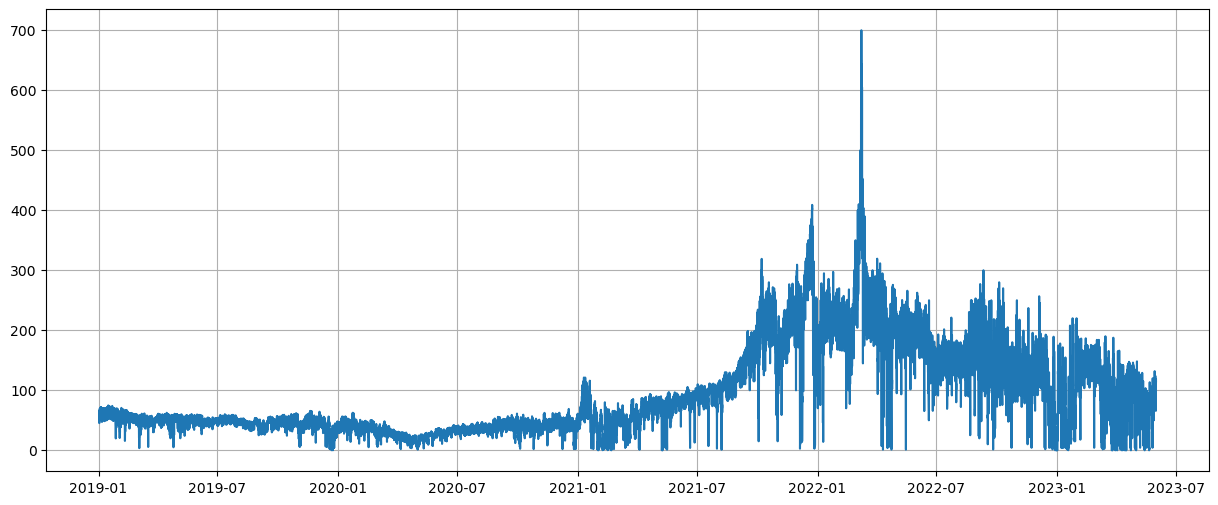

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

Se añaden variables auxiliares

In [12]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_168'] = df.Price.shift(168)

In [13]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, x in enumerate(names):
    df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [14]:
for hora in range(24):
    df['Price_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
        df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [15]:
for col in ['Price_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
    df[col+"_"+str(48)] = df[col].shift(48)
    df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)

In [16]:
for hora in range(24):
    df['Exogenous 1_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
        df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [17]:
for hora in range(24):
    df['Exogenous 2_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
        df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [18]:
for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)
for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)

In [19]:
list(df.columns)

['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
 'Price_24',
 'Price_48',
 'Price_72',
 'Price_168',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'Price_hora_0',
 'Price_hora_1',
 'Price_hora_2',
 'Price_hora_3',
 'Price_hora_4',
 'Price_hora_5',
 'Price_hora_6',
 'Price_hora_7',
 'Price_hora_8',
 'Price_hora_9',
 'Price_hora_10',
 'Price_hora_11',
 'Price_hora_12',
 'Price_hora_13',
 'Price_hora_14',
 'Price_hora_15',
 'Price_hora_16',
 'Price_hora_17',
 'Price_hora_18',
 'Price_hora_19',
 'Price_hora_20',
 'Price_hora_21',
 'Price_hora_22',
 'Price_hora_23',
 'Price_hora_0_24',
 'Price_hora_0_48',
 'Price_hora_0_72',
 'Price_hora_0_168',
 'Price_hora_1_24',
 'Price_hora_1_48',
 'Price_hora_1_72',
 'Price_hora_1_168',
 'Price_hora_2_24',
 'Price_hora_2_48',
 'Price_hora_2_72',
 'Price_hora_2_168',
 'Price_hora_3_24',
 'Price_hora_3_48',
 'Price_hora_3_72',
 'Price_hora_3_168',
 'Price_hora_4_24',
 'Price_hora_4_48',


In [20]:
columnas = ['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
 'Price_24',
 'Price_48',
 'Price_72',
 'Price_168',
 'Price_hora_0',
 'Price_hora_1',
 'Price_hora_2',
 'Price_hora_3',
 'Price_hora_4',
 'Price_hora_5',
 'Price_hora_6',
 'Price_hora_7',
 'Price_hora_8',
 'Price_hora_9',
 'Price_hora_10',
 'Price_hora_11',
 'Price_hora_12',
 'Price_hora_13',
 'Price_hora_14',
 'Price_hora_15',
 'Price_hora_16',
 'Price_hora_17',
 'Price_hora_18',
 'Price_hora_19',
 'Price_hora_20',
 'Price_hora_21',
 'Price_hora_22',
 'Price_hora_23',
 'Price_hora_0_24',
 'Price_hora_0_48',
 'Price_hora_0_72',
 'Price_hora_0_168',
 'Price_hora_1_24',
 'Price_hora_1_48',
 'Price_hora_1_72',
 'Price_hora_1_168',
 'Price_hora_2_24',
 'Price_hora_2_48',
 'Price_hora_2_72',
 'Price_hora_2_168',
 'Price_hora_3_24',
 'Price_hora_3_48',
 'Price_hora_3_72',
 'Price_hora_3_168',
 'Price_hora_4_24',
 'Price_hora_4_48',
 'Price_hora_4_72',
 'Price_hora_4_168',
 'Price_hora_5_24',
 'Price_hora_5_48',
 'Price_hora_5_72',
 'Price_hora_5_168',
 'Price_hora_6_24',
 'Price_hora_6_48',
 'Price_hora_6_72',
 'Price_hora_6_168',
 'Price_hora_7_24',
 'Price_hora_7_48',
 'Price_hora_7_72',
 'Price_hora_7_168',
 'Price_hora_8_24',
 'Price_hora_8_48',
 'Price_hora_8_72',
 'Price_hora_8_168',
 'Price_hora_9_24',
 'Price_hora_9_48',
 'Price_hora_9_72',
 'Price_hora_9_168',
 'Price_hora_10_24',
 'Price_hora_10_48',
 'Price_hora_10_72',
 'Price_hora_10_168',
 'Price_hora_11_24',
 'Price_hora_11_48',
 'Price_hora_11_72',
 'Price_hora_11_168',
 'Price_hora_12_24',
 'Price_hora_12_48',
 'Price_hora_12_72',
 'Price_hora_12_168',
 'Price_hora_13_24',
 'Price_hora_13_48',
 'Price_hora_13_72',
 'Price_hora_13_168',
 'Price_hora_14_24',
 'Price_hora_14_48',
 'Price_hora_14_72',
 'Price_hora_14_168',
 'Price_hora_15_24',
 'Price_hora_15_48',
 'Price_hora_15_72',
 'Price_hora_15_168',
 'Price_hora_16_24',
 'Price_hora_16_48',
 'Price_hora_16_72',
 'Price_hora_16_168',
 'Price_hora_17_24',
 'Price_hora_17_48',
 'Price_hora_17_72',
 'Price_hora_17_168',
 'Price_hora_18_24',
 'Price_hora_18_48',
 'Price_hora_18_72',
 'Price_hora_18_168',
 'Price_hora_19_24',
 'Price_hora_19_48',
 'Price_hora_19_72',
 'Price_hora_19_168',
 'Price_hora_20_24',
 'Price_hora_20_48',
 'Price_hora_20_72',
 'Price_hora_20_168',
 'Price_hora_21_24',
 'Price_hora_21_48',
 'Price_hora_21_72',
 'Price_hora_21_168',
 'Price_hora_22_24',
 'Price_hora_22_48',
 'Price_hora_22_72',
 'Price_hora_22_168',
 'Price_hora_23_24',
 'Price_hora_23_48',
 'Price_hora_23_72',
 'Price_hora_23_168',
 'Exogenous 1_hora_0',
 'Exogenous 1_hora_1',
 'Exogenous 1_hora_2',
 'Exogenous 1_hora_3',
 'Exogenous 1_hora_4',
 'Exogenous 1_hora_5',
 'Exogenous 1_hora_6',
 'Exogenous 1_hora_7',
 'Exogenous 1_hora_8',
 'Exogenous 1_hora_9',
 'Exogenous 1_hora_10',
 'Exogenous 1_hora_11',
 'Exogenous 1_hora_12',
 'Exogenous 1_hora_13',
 'Exogenous 1_hora_14',
 'Exogenous 1_hora_15',
 'Exogenous 1_hora_16',
 'Exogenous 1_hora_17',
 'Exogenous 1_hora_18',
 'Exogenous 1_hora_19',
 'Exogenous 1_hora_20',
 'Exogenous 1_hora_21',
 'Exogenous 1_hora_22',
 'Exogenous 1_hora_23',
 'Exogenous 2_hora_0',
 'Exogenous 2_hora_1',
 'Exogenous 2_hora_2',
 'Exogenous 2_hora_3',
 'Exogenous 2_hora_4',
 'Exogenous 2_hora_5',
 'Exogenous 2_hora_6',
 'Exogenous 2_hora_7',
 'Exogenous 2_hora_8',
 'Exogenous 2_hora_9',
 'Exogenous 2_hora_10',
 'Exogenous 2_hora_11',
 'Exogenous 2_hora_12',
 'Exogenous 2_hora_13',
 'Exogenous 2_hora_14',
 'Exogenous 2_hora_15',
 'Exogenous 2_hora_16',
 'Exogenous 2_hora_17',
 'Exogenous 2_hora_18',
 'Exogenous 2_hora_19',
 'Exogenous 2_hora_20',
 'Exogenous 2_hora_21',
 'Exogenous 2_hora_22',
 'Exogenous 2_hora_23',
 'Exogenous 1_hora_0_24',
 'Exogenous 1_hora_0_168',
 'Exogenous 1_hora_1_24',
 'Exogenous 1_hora_1_168',
 'Exogenous 1_hora_2_24',
 'Exogenous 1_hora_2_168',
 'Exogenous 1_hora_3_24',
 'Exogenous 1_hora_3_168',
 'Exogenous 1_hora_4_24',
 'Exogenous 1_hora_4_168',
 'Exogenous 1_hora_5_24',
 'Exogenous 1_hora_5_168',
 'Exogenous 1_hora_6_24',
 'Exogenous 1_hora_6_168',
 'Exogenous 1_hora_7_24',
 'Exogenous 1_hora_7_168',
 'Exogenous 1_hora_8_24',
 'Exogenous 1_hora_8_168',
 'Exogenous 1_hora_9_24',
 'Exogenous 1_hora_9_168',
 'Exogenous 1_hora_10_24',
 'Exogenous 1_hora_10_168',
 'Exogenous 1_hora_11_24',
 'Exogenous 1_hora_11_168',
 'Exogenous 1_hora_12_24',
 'Exogenous 1_hora_12_168',
 'Exogenous 1_hora_13_24',
 'Exogenous 1_hora_13_168',
 'Exogenous 1_hora_14_24',
 'Exogenous 1_hora_14_168',
 'Exogenous 1_hora_15_24',
 'Exogenous 1_hora_15_168',
 'Exogenous 1_hora_16_24',
 'Exogenous 1_hora_16_168',
 'Exogenous 1_hora_17_24',
 'Exogenous 1_hora_17_168',
 'Exogenous 1_hora_18_24',
 'Exogenous 1_hora_18_168',
 'Exogenous 1_hora_19_24',
 'Exogenous 1_hora_19_168',
 'Exogenous 1_hora_20_24',
 'Exogenous 1_hora_20_168',
 'Exogenous 1_hora_21_24',
 'Exogenous 1_hora_21_168',
 'Exogenous 1_hora_22_24',
 'Exogenous 1_hora_22_168',
 'Exogenous 1_hora_23_24',
 'Exogenous 1_hora_23_168',
 'Exogenous 2_hora_0_24',
 'Exogenous 2_hora_0_168',
 'Exogenous 2_hora_1_24',
 'Exogenous 2_hora_1_168',
 'Exogenous 2_hora_2_24',
 'Exogenous 2_hora_2_168',
 'Exogenous 2_hora_3_24',
 'Exogenous 2_hora_3_168',
 'Exogenous 2_hora_4_24',
 'Exogenous 2_hora_4_168',
 'Exogenous 2_hora_5_24',
 'Exogenous 2_hora_5_168',
 'Exogenous 2_hora_6_24',
 'Exogenous 2_hora_6_168',
 'Exogenous 2_hora_7_24',
 'Exogenous 2_hora_7_168',
 'Exogenous 2_hora_8_24',
 'Exogenous 2_hora_8_168',
 'Exogenous 2_hora_9_24',
 'Exogenous 2_hora_9_168',
 'Exogenous 2_hora_10_24',
 'Exogenous 2_hora_10_168',
 'Exogenous 2_hora_11_24',
 'Exogenous 2_hora_11_168',
 'Exogenous 2_hora_12_24',
 'Exogenous 2_hora_12_168',
 'Exogenous 2_hora_13_24',
 'Exogenous 2_hora_13_168',
 'Exogenous 2_hora_14_24',
 'Exogenous 2_hora_14_168',
 'Exogenous 2_hora_15_24',
 'Exogenous 2_hora_15_168',
 'Exogenous 2_hora_16_24',
 'Exogenous 2_hora_16_168',
 'Exogenous 2_hora_17_24',
 'Exogenous 2_hora_17_168',
 'Exogenous 2_hora_18_24',
 'Exogenous 2_hora_18_168',
 'Exogenous 2_hora_19_24',
 'Exogenous 2_hora_19_168',
 'Exogenous 2_hora_20_24',
 'Exogenous 2_hora_20_168',
 'Exogenous 2_hora_21_24',
 'Exogenous 2_hora_21_168',
 'Exogenous 2_hora_22_24',
 'Exogenous 2_hora_22_168',
 'Exogenous 2_hora_23_24',
 'Exogenous 2_hora_23_168']

columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday']

In [21]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['scaler'].append(scaler)
                    dict_new_df['Price_real'].append(row[col])
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [24]:
dict_new_df = standard_movil(df[columnas])

100%|██████████████████████████████████████████████████████████████████████████| 38664/38664 [1:09:27<00:00,  9.28it/s]


In [25]:
df = df.drop(df.head(168).index)

In [28]:
with open('dict_new_df_espana_final.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [29]:
# with open('dict_new_df_espana.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [30]:
df_nuevo = pd.DataFrame(dict_new_df)

In [31]:
for col in columnas_post:
    df_nuevo[col] = df[col].to_numpy()

In [32]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [33]:
df_scalers

,Date,scaler
0,2019-01-09 00:00:00,StandardScaler()
1,2019-01-09 01:00:00,StandardScaler()
2,2019-01-09 02:00:00,StandardScaler()
3,2019-01-09 03:00:00,StandardScaler()
4,2019-01-09 04:00:00,StandardScaler()
...,...,...
38491,2023-05-31 19:00:00,StandardScaler()
38492,2023-05-31 20:00:00,StandardScaler()
38493,2023-05-31 21:00:00,StandardScaler()
38494,2023-05-31 22:00:00,StandardScaler()


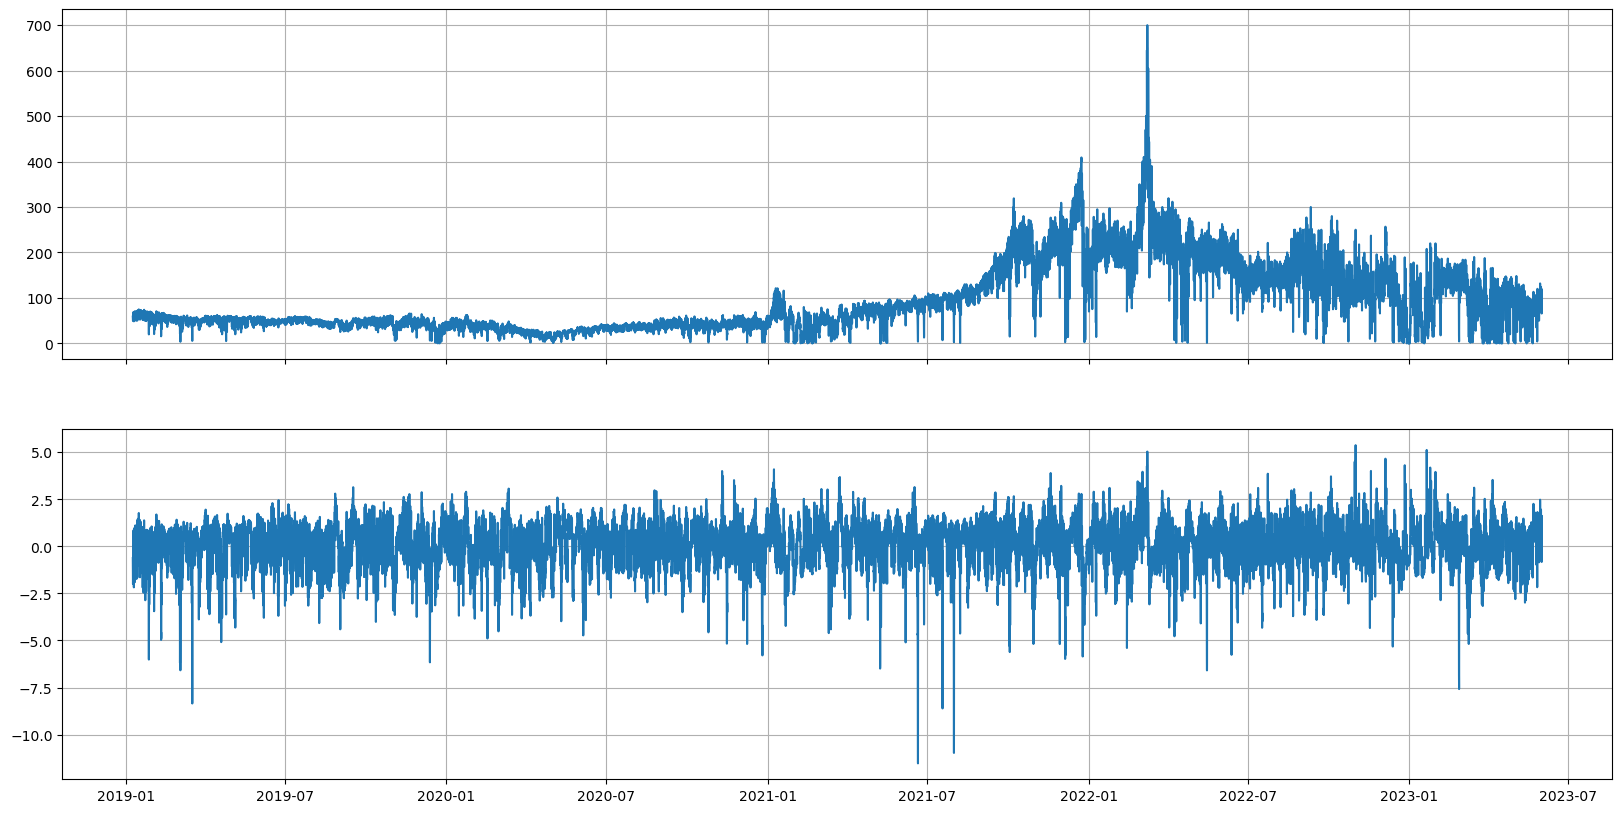

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(df_nuevo.Date, df_nuevo.Price_real)
ax[1].plot(df_nuevo.Date, df_nuevo.Price)
ax[0].grid()
ax[1].grid()

In [35]:
df_nuevo

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour,Price_24,Price_48,Price_72,Price_168,...,Exogenous 2_hora_23_168,scaler,Price_real,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2019-01-09 00:00:00,-0.622431,0.261517,1.103068,2019-01-09,0,-0.343685,0.322817,-0.216261,NaN,...,NaN,StandardScaler(),58.85,0,0,1,0,0,0,0
1,2019-01-09 01:00:00,-1.315101,-0.213463,1.076831,2019-01-09,1,-0.524667,-0.517138,-0.068623,NaN,...,NaN,StandardScaler(),54.09,0,0,1,0,0,0,0
2,2019-01-09 02:00:00,-1.546476,-0.609215,1.032458,2019-01-09,2,-1.284791,-1.315023,-1.475071,NaN,...,NaN,StandardScaler(),52.50,0,0,1,0,0,0,0
3,2019-01-09 03:00:00,-1.997585,-0.868435,1.017112,2019-01-09,3,-1.609110,-1.589205,-1.576087,NaN,...,NaN,StandardScaler(),49.40,0,0,1,0,0,0,0
4,2019-01-09 04:00:00,-1.968481,-0.982083,0.975575,2019-01-09,4,-1.810362,-1.777796,-2.506984,NaN,...,NaN,StandardScaler(),49.60,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,2023-05-31 19:00:00,-0.223699,0.773122,0.347243,2023-05-31,19,0.093731,0.131318,-0.667492,0.587096,...,-0.914923,StandardScaler(),78.89,0,0,1,0,0,0,0
38492,2023-05-31 20:00:00,0.056962,0.967939,-0.133656,2023-05-31,20,0.772586,0.175514,-0.013205,1.064396,...,-0.914923,StandardScaler(),85.00,0,0,1,0,0,0,0
38493,2023-05-31 21:00:00,0.975653,1.221458,-0.818642,2023-05-31,21,1.066069,1.945792,0.943530,1.288152,...,-0.914923,StandardScaler(),105.00,0,0,1,0,0,0,0
38494,2023-05-31 22:00:00,1.621494,1.438034,-1.182929,2023-05-31,22,1.954487,2.479085,1.268168,1.608546,...,-0.914923,StandardScaler(),119.06,0,0,1,0,0,0,0


In [41]:
df_nuevo = df_nuevo.drop(df_nuevo.head(24).index)

# Estandarización móvil + LEAR

In [2]:
with open('dict_new_df_espana_final.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [3]:
df_nuevo = pd.DataFrame(dict_new_df)

In [4]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [5]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [6]:
df_scalers

,Date,scaler
0,2019-01-09 00:00:00,StandardScaler()
1,2019-01-09 01:00:00,StandardScaler()
2,2019-01-09 02:00:00,StandardScaler()
3,2019-01-09 03:00:00,StandardScaler()
4,2019-01-09 04:00:00,StandardScaler()
...,...,...
38491,2023-05-31 19:00:00,StandardScaler()
38492,2023-05-31 20:00:00,StandardScaler()
38493,2023-05-31 21:00:00,StandardScaler()
38494,2023-05-31 22:00:00,StandardScaler()


In [7]:
df_nuevo = df_nuevo[['Date', 'Price', 'Exogenous 1', 'Exogenous 2']]

In [8]:
df = df_nuevo

In [9]:
df.index = df.Date

In [10]:
df = df.drop(['Date'], axis = 1)

In [11]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [12]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [13]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [14]:
forecast_dates = forecast.index

In [15]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [16]:
calibration_window = 2*364

In [17]:
model = LEAR(calibration_window=calibration_window)

In [18]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [19]:
df_original = pd.read_csv(r"Data/df_espana_final.csv")

In [20]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [21]:
df_original = df_original.fillna(0)

In [22]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Exogenous 4    0
dtype: int64

In [23]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3'] + df_original['Exogenous 4']
df_original = df_original.drop(['Exogenous 3', 'Exogenous 4'], axis = 1)

In [24]:
df_original.index = df_original.Date

In [25]:
df_original = df_original.drop(['Date'], axis = 1)

In [26]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [27]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,127.81,145.86,114.90,113.87,97.80,97.80,95.74,97.80,97.80,97.80,...,96.80,97.80,98.52,114.50,149.97,177.22,187.52,189.26,190.81,188.39
2022-01-02,167.26,133.21,115.87,110.52,113.00,115.87,110.52,115.87,129.60,115.87,...,110.52,115.87,109.50,115.87,159.79,194.25,198.00,208.38,209.10,191.36
2022-01-03,178.00,181.50,160.72,154.64,149.86,144.49,148.86,153.77,160.72,189.26,...,142.04,127.38,112.87,126.80,148.49,175.06,180.00,153.77,141.94,114.11
2022-01-04,100.36,125.47,115.55,113.29,105.81,105.00,115.11,153.77,161.03,178.91,...,179.59,163.20,157.30,157.30,163.78,184.94,178.99,156.12,148.65,137.92
2022-01-05,105.00,120.11,105.10,84.50,75.38,79.11,94.79,169.04,206.07,211.13,...,197.34,195.60,200.00,206.07,211.23,225.00,250.34,241.93,218.95,207.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,99.77,96.86,90.00,84.73,81.35,84.85,87.26,90.27,87.29,87.26,...,82.01,66.75,61.71,57.85,58.41,84.85,95.11,100.82,108.21,109.35
2023-05-28,110.00,105.42,100.00,99.37,100.00,100.00,100.00,97.85,90.42,83.06,...,70.47,69.57,54.17,50.00,51.00,55.00,73.28,100.01,109.08,115.38
2023-05-29,107.64,91.84,91.84,84.75,84.75,84.75,85.80,100.00,112.89,110.20,...,84.45,83.85,81.42,80.00,81.00,84.05,84.95,121.00,131.86,129.40


In [35]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 23.97%  |  MAE: 22.055
2022-01-02 - sMAPE: 19.09%  |  MAE: 21.104
2022-01-03 - sMAPE: 20.11%  |  MAE: 26.333
2022-01-04 - sMAPE: 21.48%  |  MAE: 27.856
2022-01-05 - sMAPE: 21.97%  |  MAE: 30.442
2022-01-06 - sMAPE: 23.52%  |  MAE: 34.765
2022-01-07 - sMAPE: 22.27%  |  MAE: 33.935
2022-01-08 - sMAPE: 21.46%  |  MAE: 33.415
2022-01-09 - sMAPE: 22.52%  |  MAE: 33.072
2022-01-10 - sMAPE: 21.12%  |  MAE: 31.341
2022-01-11 - sMAPE: 20.17%  |  MAE: 30.884
2022-01-12 - sMAPE: 19.68%  |  MAE: 31.091
2022-01-13 - sMAPE: 19.57%  |  MAE: 32.066
2022-01-14 - sMAPE: 19.64%  |  MAE: 33.231
2022-01-15 - sMAPE: 18.66%  |  MAE: 31.727
2022-01-16 - sMAPE: 17.93%  |  MAE: 30.602
2022-01-17 - sMAPE: 17.12%  |  MAE: 29.404
2022-01-18 - sMAPE: 16.74%  |  MAE: 29.090
2022-01-19 - sMAPE: 16.10%  |  MAE: 28.076
2022-01-20 - sMAPE: 15.50%  |  MAE: 27.044
2022-01-21 - sMAPE: 14.93%  |  MAE: 26.040
2022-01-22 - sMAPE: 14.45%  |  MAE: 25.256
2022-01-23 - sMAPE: 13.96%  |  MAE: 24.441
2022-01-24 

2022-07-11 - sMAPE: 11.60%  |  MAE: 20.791
2022-07-12 - sMAPE: 11.59%  |  MAE: 20.765
2022-07-13 - sMAPE: 11.58%  |  MAE: 20.744
2022-07-14 - sMAPE: 11.56%  |  MAE: 20.693
2022-07-15 - sMAPE: 11.52%  |  MAE: 20.627
2022-07-16 - sMAPE: 11.53%  |  MAE: 20.613
2022-07-17 - sMAPE: 11.63%  |  MAE: 20.688
2022-07-18 - sMAPE: 11.63%  |  MAE: 20.656
2022-07-19 - sMAPE: 11.73%  |  MAE: 20.737
2022-07-20 - sMAPE: 11.71%  |  MAE: 20.691
2022-07-21 - sMAPE: 11.68%  |  MAE: 20.625
2022-07-22 - sMAPE: 11.65%  |  MAE: 20.563
2022-07-23 - sMAPE: 11.72%  |  MAE: 20.637
2022-07-24 - sMAPE: 11.71%  |  MAE: 20.598
2022-07-25 - sMAPE: 11.70%  |  MAE: 20.567
2022-07-26 - sMAPE: 11.67%  |  MAE: 20.512
2022-07-27 - sMAPE: 11.63%  |  MAE: 20.436
2022-07-28 - sMAPE: 11.62%  |  MAE: 20.410
2022-07-29 - sMAPE: 11.62%  |  MAE: 20.402
2022-07-30 - sMAPE: 11.60%  |  MAE: 20.352
2022-07-31 - sMAPE: 11.61%  |  MAE: 20.332
2022-08-01 - sMAPE: 11.58%  |  MAE: 20.271
2022-08-02 - sMAPE: 11.55%  |  MAE: 20.207
2022-08-03 

2023-01-18 - sMAPE: 18.00%  |  MAE: 19.737
2023-01-19 - sMAPE: 18.13%  |  MAE: 19.729
2023-01-20 - sMAPE: 18.29%  |  MAE: 19.791
2023-01-21 - sMAPE: 18.31%  |  MAE: 19.786
2023-01-22 - sMAPE: 18.45%  |  MAE: 19.773
2023-01-23 - sMAPE: 18.45%  |  MAE: 19.751
2023-01-24 - sMAPE: 18.44%  |  MAE: 19.740
2023-01-25 - sMAPE: 18.42%  |  MAE: 19.721
2023-01-26 - sMAPE: 18.43%  |  MAE: 19.716
2023-01-27 - sMAPE: 18.44%  |  MAE: 19.698
2023-01-28 - sMAPE: 18.46%  |  MAE: 19.669
2023-01-29 - sMAPE: 18.46%  |  MAE: 19.657
2023-01-30 - sMAPE: 18.45%  |  MAE: 19.654
2023-01-31 - sMAPE: 18.43%  |  MAE: 19.633
2023-02-01 - sMAPE: 18.41%  |  MAE: 19.617
2023-02-02 - sMAPE: 18.40%  |  MAE: 19.607
2023-02-03 - sMAPE: 18.37%  |  MAE: 19.586
2023-02-04 - sMAPE: 18.39%  |  MAE: 19.603
2023-02-05 - sMAPE: 18.42%  |  MAE: 19.587
2023-02-06 - sMAPE: 18.40%  |  MAE: 19.568
2023-02-07 - sMAPE: 18.37%  |  MAE: 19.548
2023-02-08 - sMAPE: 18.34%  |  MAE: 19.518
2023-02-09 - sMAPE: 18.31%  |  MAE: 19.491
2023-02-10 

In [36]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,129.356664,106.778359,89.589494,81.158901,73.149642,66.317573,58.865771,41.844437,39.317983,44.332382,...,95.223484,99.092746,98.707286,111.279869,131.440606,152.644964,161.660534,170.201231,174.365395,164.382821
2022-01-02,157.579546,142.996497,124.569534,113.887646,103.481828,101.48422,110.737704,118.533801,120.681904,120.482228,...,145.519513,153.933375,157.401677,172.11853,203.509317,219.027103,222.708561,219.132193,216.829107,208.450814
2022-01-03,165.821969,158.862525,144.552087,133.386272,125.946565,126.844727,139.600434,168.122181,198.242194,213.34746,...,185.228498,179.712893,177.345622,189.372674,205.110737,217.358905,221.321755,212.302626,195.128381,167.576416
2022-01-04,111.134219,95.581486,79.39952,73.369194,66.728274,65.881444,73.079484,90.048719,122.293085,144.279002,...,134.330504,120.680008,122.302712,128.082791,142.328684,154.312305,161.777478,156.714738,142.726705,122.856854
2022-01-05,123.05741,110.546725,98.071863,85.84294,76.063011,73.586412,89.170433,106.976833,136.712864,155.46544,...,131.907279,129.589816,138.278452,152.939364,172.879967,190.566976,201.33686,193.888662,183.050303,172.219068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,100.418768,97.266243,84.61987,77.696388,73.923787,74.104955,78.51428,88.346762,89.977126,89.889141,...,56.297991,49.586833,45.107606,50.605225,61.111978,71.311964,89.361777,108.581362,124.266304,121.691399
2023-05-28,98.081944,103.27415,92.310289,86.8497,84.159364,83.608247,86.269162,85.798629,80.593694,74.40839,...,57.130448,52.956202,45.830136,48.880511,57.96724,68.475151,84.225487,104.704752,116.884144,118.44129
2023-05-29,99.649299,101.5849,92.859374,88.585214,85.85272,85.402485,87.289527,97.477904,107.816619,108.942216,...,86.018938,84.666086,77.87209,73.461623,79.123485,88.278521,99.33783,112.445562,116.493648,113.283452


In [37]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_2_anos_ventana.csv")

In [38]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [39]:
forecast_dates = forecast.index

In [40]:
calibration_window = 1*364

In [41]:
model = LEAR(calibration_window=calibration_window)

In [42]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 14.96%  |  MAE: 15.605
2022-01-02 - sMAPE: 13.77%  |  MAE: 16.120
2022-01-03 - sMAPE: 15.01%  |  MAE: 20.138
2022-01-04 - sMAPE: 17.35%  |  MAE: 22.806
2022-01-05 - sMAPE: 19.17%  |  MAE: 26.978
2022-01-06 - sMAPE: 21.40%  |  MAE: 32.189
2022-01-07 - sMAPE: 20.83%  |  MAE: 32.339
2022-01-08 - sMAPE: 20.23%  |  MAE: 32.024
2022-01-09 - sMAPE: 21.59%  |  MAE: 32.035
2022-01-10 - sMAPE: 20.50%  |  MAE: 30.706
2022-01-11 - sMAPE: 19.58%  |  MAE: 30.239
2022-01-12 - sMAPE: 19.20%  |  MAE: 30.656
2022-01-13 - sMAPE: 19.21%  |  MAE: 31.918
2022-01-14 - sMAPE: 19.55%  |  MAE: 33.709
2022-01-15 - sMAPE: 18.44%  |  MAE: 31.877
2022-01-16 - sMAPE: 17.49%  |  MAE: 30.311
2022-01-17 - sMAPE: 16.71%  |  MAE: 29.137
2022-01-18 - sMAPE: 16.36%  |  MAE: 28.847
2022-01-19 - sMAPE: 15.81%  |  MAE: 27.989
2022-01-20 - sMAPE: 15.28%  |  MAE: 27.082
2022-01-21 - sMAPE: 14.75%  |  MAE: 26.138
2022-01-22 - sMAPE: 14.28%  |  MAE: 25.344
2022-01-23 - sMAPE: 13.78%  |  MAE: 24.492
2022-01-24 

2022-07-11 - sMAPE: 11.92%  |  MAE: 21.711
2022-07-12 - sMAPE: 11.91%  |  MAE: 21.672
2022-07-13 - sMAPE: 11.89%  |  MAE: 21.622
2022-07-14 - sMAPE: 11.86%  |  MAE: 21.562
2022-07-15 - sMAPE: 11.83%  |  MAE: 21.500
2022-07-16 - sMAPE: 11.83%  |  MAE: 21.481
2022-07-17 - sMAPE: 11.95%  |  MAE: 21.576
2022-07-18 - sMAPE: 11.96%  |  MAE: 21.548
2022-07-19 - sMAPE: 12.00%  |  MAE: 21.576
2022-07-20 - sMAPE: 11.99%  |  MAE: 21.529
2022-07-21 - sMAPE: 11.96%  |  MAE: 21.466
2022-07-22 - sMAPE: 11.94%  |  MAE: 21.407
2022-07-23 - sMAPE: 12.00%  |  MAE: 21.466
2022-07-24 - sMAPE: 11.98%  |  MAE: 21.415
2022-07-25 - sMAPE: 11.96%  |  MAE: 21.376
2022-07-26 - sMAPE: 11.94%  |  MAE: 21.320
2022-07-27 - sMAPE: 11.90%  |  MAE: 21.246
2022-07-28 - sMAPE: 11.89%  |  MAE: 21.225
2022-07-29 - sMAPE: 11.89%  |  MAE: 21.211
2022-07-30 - sMAPE: 11.88%  |  MAE: 21.163
2022-07-31 - sMAPE: 11.89%  |  MAE: 21.145
2022-08-01 - sMAPE: 11.86%  |  MAE: 21.077
2022-08-02 - sMAPE: 11.82%  |  MAE: 21.008
2022-08-03 

2023-01-18 - sMAPE: 18.08%  |  MAE: 20.191
2023-01-19 - sMAPE: 18.22%  |  MAE: 20.182
2023-01-20 - sMAPE: 18.39%  |  MAE: 20.249
2023-01-21 - sMAPE: 18.40%  |  MAE: 20.227
2023-01-22 - sMAPE: 18.51%  |  MAE: 20.209
2023-01-23 - sMAPE: 18.53%  |  MAE: 20.191
2023-01-24 - sMAPE: 18.52%  |  MAE: 20.173
2023-01-25 - sMAPE: 18.49%  |  MAE: 20.147
2023-01-26 - sMAPE: 18.49%  |  MAE: 20.134
2023-01-27 - sMAPE: 18.50%  |  MAE: 20.110
2023-01-28 - sMAPE: 18.51%  |  MAE: 20.081
2023-01-29 - sMAPE: 18.52%  |  MAE: 20.067
2023-01-30 - sMAPE: 18.53%  |  MAE: 20.088
2023-01-31 - sMAPE: 18.51%  |  MAE: 20.064
2023-02-01 - sMAPE: 18.50%  |  MAE: 20.054
2023-02-02 - sMAPE: 18.49%  |  MAE: 20.047
2023-02-03 - sMAPE: 18.46%  |  MAE: 20.022
2023-02-04 - sMAPE: 18.46%  |  MAE: 20.028
2023-02-05 - sMAPE: 18.49%  |  MAE: 20.013
2023-02-06 - sMAPE: 18.47%  |  MAE: 20.000
2023-02-07 - sMAPE: 18.45%  |  MAE: 19.976
2023-02-08 - sMAPE: 18.41%  |  MAE: 19.946
2023-02-09 - sMAPE: 18.38%  |  MAE: 19.920
2023-02-10 

In [43]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,128.816475,120.319148,107.636728,109.598264,95.703791,90.501414,78.802204,57.078556,56.287913,61.973109,...,105.789326,106.528301,107.082122,121.624371,128.911332,154.805715,164.416028,168.447047,170.824458,172.730017
2022-01-02,162.142541,147.343426,137.870622,123.735164,117.382805,118.225166,123.969564,114.699318,114.187044,118.687829,...,143.374405,145.09304,153.082988,167.898048,183.717081,188.215172,201.643841,214.238536,211.237482,195.533057
2022-01-03,167.130536,159.168405,145.246888,137.373775,126.49833,131.620032,145.464451,154.054552,184.91413,204.288264,...,170.015081,160.790632,170.040265,184.780891,194.258282,201.261134,202.052429,210.073195,193.231163,161.832044
2022-01-04,109.368272,103.241033,83.64848,75.78789,66.323709,62.031451,73.694117,87.478725,127.812767,151.772191,...,136.7394,124.821425,121.383512,134.056636,145.930522,157.533241,165.967268,156.920995,144.15139,119.298626
2022-01-05,126.996778,115.75183,99.251964,81.762173,70.48056,64.320613,77.144357,100.201968,132.498239,157.338601,...,130.354816,132.319971,135.848047,148.638273,171.748921,182.346994,191.80862,186.497063,179.336283,174.86277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,101.558964,97.474722,86.719471,80.480028,74.972425,75.840083,79.204484,84.397467,89.785724,88.015229,...,52.35343,46.385545,42.360362,46.291376,61.403687,74.942125,93.210687,111.112482,126.824896,123.641669
2023-05-28,99.148721,104.233731,96.078278,93.208727,88.589606,88.028905,90.77471,90.90587,88.18378,82.893943,...,62.837961,59.633527,54.719808,52.770865,61.147835,72.15802,88.82604,110.024108,122.23423,120.930397
2023-05-29,100.406228,100.612569,94.353442,89.819502,86.788996,85.697117,89.920084,96.787375,107.26918,110.307336,...,83.780018,82.017177,77.700685,77.288138,81.304257,85.061724,99.276344,115.293534,118.598733,113.927884


In [44]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_1_ano_ventana.csv")

In [28]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [29]:
forecast_dates = forecast.index

In [30]:
calibration_window = 182

In [31]:
model = LEAR(calibration_window=calibration_window)

In [32]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 14.04%  |  MAE: 13.902
2022-01-02 - sMAPE: 13.63%  |  MAE: 15.530
2022-01-03 - sMAPE: 13.40%  |  MAE: 17.121
2022-01-04 - sMAPE: 16.87%  |  MAE: 21.162
2022-01-05 - sMAPE: 19.72%  |  MAE: 26.464
2022-01-06 - sMAPE: 21.18%  |  MAE: 30.682
2022-01-07 - sMAPE: 20.60%  |  MAE: 31.011
2022-01-08 - sMAPE: 19.76%  |  MAE: 30.450
2022-01-09 - sMAPE: 21.50%  |  MAE: 30.996
2022-01-10 - sMAPE: 20.84%  |  MAE: 30.686
2022-01-11 - sMAPE: 19.82%  |  MAE: 30.029
2022-01-12 - sMAPE: 19.01%  |  MAE: 29.432
2022-01-13 - sMAPE: 18.78%  |  MAE: 30.049
2022-01-14 - sMAPE: 18.88%  |  MAE: 31.239
2022-01-15 - sMAPE: 17.95%  |  MAE: 29.862
2022-01-16 - sMAPE: 16.98%  |  MAE: 28.300
2022-01-17 - sMAPE: 16.30%  |  MAE: 27.425
2022-01-18 - sMAPE: 15.99%  |  MAE: 27.287
2022-01-19 - sMAPE: 15.52%  |  MAE: 26.658
2022-01-20 - sMAPE: 15.19%  |  MAE: 26.193
2022-01-21 - sMAPE: 14.74%  |  MAE: 25.441
2022-01-22 - sMAPE: 14.25%  |  MAE: 24.632
2022-01-23 - sMAPE: 13.75%  |  MAE: 23.812
2022-01-24 

2022-07-11 - sMAPE: 11.97%  |  MAE: 21.635
2022-07-12 - sMAPE: 11.95%  |  MAE: 21.591
2022-07-13 - sMAPE: 11.91%  |  MAE: 21.512
2022-07-14 - sMAPE: 11.88%  |  MAE: 21.463
2022-07-15 - sMAPE: 11.86%  |  MAE: 21.408
2022-07-16 - sMAPE: 11.85%  |  MAE: 21.373
2022-07-17 - sMAPE: 11.96%  |  MAE: 21.453
2022-07-18 - sMAPE: 11.98%  |  MAE: 21.431
2022-07-19 - sMAPE: 12.08%  |  MAE: 21.517
2022-07-20 - sMAPE: 12.09%  |  MAE: 21.500
2022-07-21 - sMAPE: 12.07%  |  MAE: 21.454
2022-07-22 - sMAPE: 12.06%  |  MAE: 21.404
2022-07-23 - sMAPE: 12.11%  |  MAE: 21.453
2022-07-24 - sMAPE: 12.08%  |  MAE: 21.390
2022-07-25 - sMAPE: 12.08%  |  MAE: 21.367
2022-07-26 - sMAPE: 12.06%  |  MAE: 21.325
2022-07-27 - sMAPE: 12.02%  |  MAE: 21.254
2022-07-28 - sMAPE: 12.03%  |  MAE: 21.258
2022-07-29 - sMAPE: 12.03%  |  MAE: 21.236
2022-07-30 - sMAPE: 12.02%  |  MAE: 21.201
2022-07-31 - sMAPE: 12.04%  |  MAE: 21.182
2022-08-01 - sMAPE: 12.02%  |  MAE: 21.138
2022-08-02 - sMAPE: 11.99%  |  MAE: 21.084
2022-08-03 

2023-01-18 - sMAPE: 17.99%  |  MAE: 20.291
2023-01-19 - sMAPE: 18.13%  |  MAE: 20.280
2023-01-20 - sMAPE: 18.32%  |  MAE: 20.353
2023-01-21 - sMAPE: 18.31%  |  MAE: 20.323
2023-01-22 - sMAPE: 18.42%  |  MAE: 20.307
2023-01-23 - sMAPE: 18.46%  |  MAE: 20.301
2023-01-24 - sMAPE: 18.45%  |  MAE: 20.283
2023-01-25 - sMAPE: 18.42%  |  MAE: 20.255
2023-01-26 - sMAPE: 18.41%  |  MAE: 20.231
2023-01-27 - sMAPE: 18.40%  |  MAE: 20.198
2023-01-28 - sMAPE: 18.40%  |  MAE: 20.170
2023-01-29 - sMAPE: 18.40%  |  MAE: 20.154
2023-01-30 - sMAPE: 18.42%  |  MAE: 20.170
2023-01-31 - sMAPE: 18.41%  |  MAE: 20.167
2023-02-01 - sMAPE: 18.44%  |  MAE: 20.190
2023-02-02 - sMAPE: 18.44%  |  MAE: 20.196
2023-02-03 - sMAPE: 18.41%  |  MAE: 20.171
2023-02-04 - sMAPE: 18.42%  |  MAE: 20.178
2023-02-05 - sMAPE: 18.45%  |  MAE: 20.169
2023-02-06 - sMAPE: 18.44%  |  MAE: 20.163
2023-02-07 - sMAPE: 18.41%  |  MAE: 20.132
2023-02-08 - sMAPE: 18.38%  |  MAE: 20.099
2023-02-09 - sMAPE: 18.35%  |  MAE: 20.076
2023-02-10 

In [33]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,128.989012,134.483101,130.960315,120.905325,114.432637,109.60594,109.602868,65.092386,55.225644,70.988224,...,98.889266,98.040277,106.122409,114.046234,139.800612,167.354133,194.065055,198.075664,198.298335,184.177962
2022-01-02,153.812426,152.363076,143.484511,131.542434,124.721923,121.041341,124.711407,112.993316,111.595369,124.066943,...,143.093953,149.006676,141.886925,140.828988,155.28426,185.556122,202.71928,210.572098,213.255592,200.600932
2022-01-03,160.77937,162.491188,154.852445,141.813496,133.563127,127.400391,139.502374,159.526228,181.234422,208.476874,...,154.68422,152.421662,146.960258,147.400803,160.472525,181.647569,197.621407,204.910687,187.65862,155.728139
2022-01-04,118.097328,104.910269,88.309692,70.657386,56.537716,51.260069,67.997294,86.026823,123.815225,161.120426,...,113.198106,117.482052,119.109269,127.360907,146.909437,162.433328,177.859746,173.244118,155.037323,124.254216
2022-01-05,130.175202,110.810778,89.939768,71.471387,56.611296,52.052054,67.131625,91.949399,126.655197,158.051764,...,123.748317,124.067835,132.91517,145.078932,165.07362,177.736137,193.15726,193.006138,186.630783,170.812282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,104.625816,94.645401,87.798841,84.62407,81.490165,75.8008,86.56061,88.020897,93.762007,91.538376,...,57.773866,48.472044,47.838371,48.039711,63.451424,76.570381,97.831418,112.631026,120.345914,114.569848
2023-05-28,104.148945,98.259535,95.083453,94.257993,92.168743,91.529891,94.283794,92.332848,88.367582,82.642125,...,62.376343,58.40761,53.272056,52.170296,62.044038,72.015495,92.947733,110.604482,116.820834,114.61636
2023-05-29,101.113799,100.257956,97.243681,94.398943,93.476424,92.515917,95.875487,101.369894,106.330827,105.96134,...,83.712825,79.906243,75.204975,75.597852,73.616647,81.10766,94.077918,106.603226,109.219661,106.941052


In [34]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_6_meses_ventana.csv")

In [28]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [29]:
forecast_dates = forecast.index

In [30]:
calibration_window = None

In [31]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 20.34%  |  MAE: 19.757
2022-01-02 - sMAPE: 17.26%  |  MAE: 19.684
2022-01-03 - sMAPE: 18.93%  |  MAE: 25.554
2022-01-04 - sMAPE: 20.42%  |  MAE: 27.042
2022-01-05 - sMAPE: 21.00%  |  MAE: 29.387
2022-01-06 - sMAPE: 22.76%  |  MAE: 33.961
2022-01-07 - sMAPE: 21.45%  |  MAE: 32.906
2022-01-08 - sMAPE: 20.49%  |  MAE: 32.117
2022-01-09 - sMAPE: 21.50%  |  MAE: 31.655
2022-01-10 - sMAPE: 20.44%  |  MAE: 30.354
2022-01-11 - sMAPE: 19.52%  |  MAE: 29.897
2022-01-12 - sMAPE: 19.05%  |  MAE: 30.100
2022-01-13 - sMAPE: 18.92%  |  MAE: 30.966
2022-01-14 - sMAPE: 18.92%  |  MAE: 31.906
2022-01-15 - sMAPE: 18.06%  |  MAE: 30.633
2022-01-16 - sMAPE: 17.34%  |  MAE: 29.526
2022-01-17 - sMAPE: 16.58%  |  MAE: 28.402
2022-01-18 - sMAPE: 16.22%  |  MAE: 28.146
2022-01-19 - sMAPE: 15.62%  |  MAE: 27.181
2022-01-20 - sMAPE: 15.04%  |  MAE: 26.212
2022-01-21 - sMAPE: 14.53%  |  MAE: 25.317
2022-01-22 - sMAPE: 14.05%  |  MAE: 24.506
2022-01-23 - sMAPE: 13.59%  |  MAE: 23.741
2022-01-24 

In [35]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,130.116931,116.841192,100.47517,90.001933,74.809897,70.000081,64.699788,44.883397,43.758554,50.94766,...,100.546726,100.350593,97.444529,107.119832,126.814703,152.990118,165.240571,170.502791,168.974925,159.800111
2022-01-02,161.944501,144.402946,124.66782,116.439388,104.489965,99.665023,103.776785,115.280661,116.607322,119.879802,...,147.204794,154.090944,152.277687,160.372521,185.136905,215.357225,224.89108,219.50303,219.49713,206.390362
2022-01-03,170.944759,156.283534,143.57487,135.311821,127.914684,126.553788,138.384025,168.608605,207.004402,219.756181,...,186.706188,176.969358,177.311011,187.719302,206.902628,222.187788,222.039573,210.509248,186.762735,153.786988
2022-01-04,108.729902,96.72402,82.7473,74.89319,66.275284,63.986625,71.653905,89.289372,121.343238,146.152007,...,133.746821,123.525153,122.230317,130.433447,143.830253,160.101743,166.45325,159.459161,145.319051,124.97756
2022-01-05,117.76399,107.466252,93.728103,81.370733,71.115714,67.958566,80.217639,105.524699,137.916606,156.786429,...,135.736292,135.234036,141.770638,155.012736,177.059287,195.957134,203.57448,196.602131,192.03187,181.021025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,106.765541,101.198574,94.243614,90.638063,88.000614,88.844521,87.552073,94.48868,91.303658,88.192274,...,47.047227,43.640656,35.063388,34.115371,49.851803,67.40174,85.713246,101.451332,116.362505,115.066123
2023-05-28,101.596106,103.201466,94.938895,89.101371,84.377351,82.595724,83.273597,80.998548,73.308529,67.888779,...,49.664015,45.729923,36.273535,34.167668,42.656354,63.365494,80.889898,99.222769,114.401742,117.738299
2023-05-29,102.170214,99.32539,92.854699,88.859673,86.301977,85.593079,90.656035,101.500501,109.916831,110.641803,...,86.359588,83.893058,79.369677,78.012073,81.810532,87.868736,99.796776,113.812189,117.544233,114.212281


In [36]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_espana_final_sin_ventana.csv")